<table width="100%">
  <tr>
    <td width="25%" align="left">
      <img src="https://www.valoraanalitik.com/wp-content/uploads/2022/04/SERVIBRASIL.jpg" width="140">
    </td>
    <td width="50%" align="center">
      <h1 style="font-size: 80px; margin-bottom: 0;"> BootCamp 2025</h1>
    </td>
    <td width="25%" align="right">
      <img src="https://logodownload.org/wp-content/uploads/2021/06/google-cloud-logo-1.png" width="140">
    </td>
  </tr>
</table>

# 🚀 **Bootcamp: Análise de Vendas no Brasil usando BigQuery ML and Vertex AI**

<div align="justify">

Neste notebook, você realizará análises práticas utilizando dados reais de vendas no Brasil. Vamos explorar as poderosas ferramentas do **BigQuery e BigQuery ML** para:

1. 🔍 **Explorar e visualizar os dados (EDA):** Descubra padrões, tendências e insights por meio de análises exploratórias.
2. 🛍️ **Segmentar lojas usando clustering (K-means):** Agrupe lojas com comportamentos de vendas semelhantes para identificar segmentos estratégicos.
3. 📈 **Prever as vendas futuras utilizando modelos de séries temporais (ARIMA_PLUS):** Desenvolva modelos para estimar a evolução das vendas ao longo do tempo.
4. ✨ **Prever as vendas futuras usando Vertex AI (XGBoost - Custom Jobs):** Experimente um fluxo de trabalho avançado de Machine Learning.

🗂️ O conjunto de dados inclui:
- Registros de vendas
- Detalhes das transações
- Catálogo de produtos


</div>

# **0. Introdução**

### 🔌 **Executando Consultas no BigQuery a partir do Vertex AI Workbench**

No Vertex AI Workbench, a forma mais recomendada de executar consultas SQL no BigQuery é utilizando a função `read_gbq()` da biblioteca `pandas_gbq`.

📌 **Exemplo de uso com `read_gbq()`**

```python
from pandas_gbq import read_gbq

query = """
SELECT *
FROM `seu_projeto.seu_dataset.sua_tabela`
LIMIT 10
"""

df = read_gbq(query, project_id="seu_projeto")
df.head()


# **1. Conectar ao BigQuery**

In [2]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from pandas_gbq import read_gbq
import warnings

warnings.filterwarnings("ignore", category=UserWarning) #para silenciar avisos (aqui por questões de versões)

# 🔧 Definir configurações do projeto GCP
project_id = 'bc-gcp-servibrasil-25-servi'
dataset_id = 'bc-gcp-servibrasil-25-servi.dataset_bootcamp'
dataset_location = 'US'

# 🌍 (Opcional) Definir como variável de ambiente
os.environ["PROJECT_ID"] = project_id

# 🛠️ (Opcional) Inicializar cliente BigQuery (caso queira executar queries diretamente via Python)
bqclient = bigquery.Client(project=project_id)

# **2. Análise Exploratória de Dados (EDA)**

Agora vamos explorar o conjunto de dados para entender os principais padrões de comportamento nas vendas:

- Como as vendas mudaram ao longo do tempo?
- Quais produtos são os mais vendidos?
- Quais lojas estão gerando mais receita?

Os dados vêm de duas tabelas:
- `vendas` (vendas realizadas)
- `detalhe_vendas_bq` (detalhes das vendas)

### 🟢 **Instrução**

Execute a célula abaixo


In [4]:
# 📥 Definir o número de registros que queremos visualizar
limit = 4
projeto = "bc-gcp-servibrasil-25-servi"
dataset = "dataset_bootcamp"
vendas = "vendas"

# 🧾 Consulta SQL para unir vendas com os detalhes de cada venda
query_vendas1 = f"""
SELECT
  A.id_venda,
  A.pais,
  A.id_ponto_venda,
  A.data_venda,
  A.total,
  B.id_produto,
  B.quantidade,
  B.desconto
FROM `{projeto}.{dataset}.{vendas}` AS A
LEFT JOIN `bc-gcp-servibrasil-25-servi.dataset_bootcamp.detalhes_de_venda` AS B
  ON A.id_venda = B.id_venda
ORDER BY data_venda DESC
LIMIT {limit}
"""

# 🔄 Executar a consulta e carregar como DataFrame pandas
df_vendas1 = read_gbq(query_vendas1, project_id=project_id)
df_vendas1.head()

Downloading: 100%|██████████|


,id_venda,pais,id_ponto_venda,data_venda,total,id_produto,quantidade,desconto
0,48199,Brasil,6,2024-09-18,873.17,28,6,14.55
1,48199,Brasil,6,2024-09-18,873.17,38,7,5.60
2,35925,Brasil,19,2024-09-18,806.79,12,3,5.44
3,48199,Brasil,6,2024-09-18,873.17,54,10,9.25


### 🟢 **Instrução**

Vamos calcular a receita total por dia para visualizar as tendências de vendas ao longo do tempo.



In [6]:
# 📊 Consulta SQL para obter vendas diárias agregadas (últimos 30 dias)
query_day_sal = f"""
SELECT
  data_venda,
  SUM(total) AS daily_total_sales
FROM `{projeto}.{dataset}.{vendas}`
GROUP BY data_venda
ORDER BY data_venda
LIMIT 30
"""

# 🔄 Executar a consulta e carregar como DataFrame pandas
df_daily_sales = read_gbq(query_day_sal, project_id=project_id)
df_daily_sales.head()

Downloading: 100%|██████████|


,data_venda,daily_total_sales
0,2022-09-19,38692.54
1,2022-09-20,35148.36
2,2022-09-21,38907.99
3,2022-09-22,37316.55
4,2022-09-23,37541.30


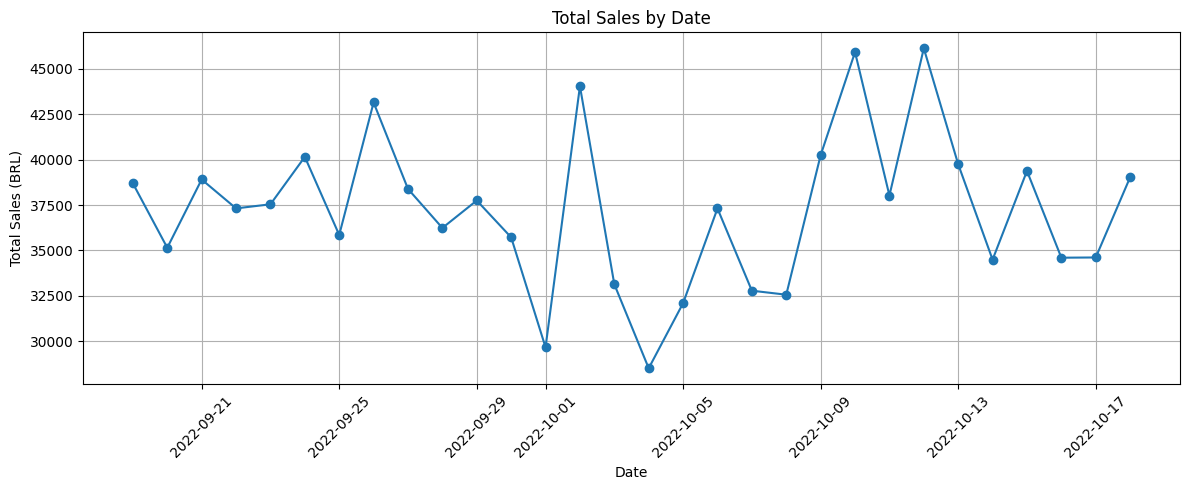

In [7]:
# 📅 Ordenar os dados pela data
df_daily_sales = df_daily_sales.sort_values("data_venda")

# 📊 Visualizar a série temporal de vendas diárias
plt.figure(figsize=(12, 5))
plt.plot(df_daily_sales['data_venda'], df_daily_sales['daily_total_sales'], marker='o', linestyle='-')
plt.title("Total Sales by Date")
plt.xlabel("Date")
plt.ylabel("Total Sales (BRL)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### 🟢 **Instrução**

Agora vamos calcular a quantidade total vendida por produto usando a tabela `detalhe_vendas_bq`.



In [9]:
# 🛍️ Consulta SQL para obter os 10 produtos mais vendidos
query_top_products = f"""
SELECT
  P.id_produto,
  SUM(D.quantidade) AS total_quantity
FROM `{projeto}.{dataset}.detalhes_de_venda` AS D
JOIN `{projeto}.{dataset}.produtos` AS P
  ON D.id_produto = P.id_produto
GROUP BY P.id_produto
ORDER BY total_quantity DESC
LIMIT 10
"""

# 🔄 Executar a consulta e carregar o resultado como DataFrame
df_top_products = read_gbq(query_top_products, project_id=project_id)
df_top_products.head()


Downloading: 100%|██████████|


,id_produto,total_quantity
0,3,10643
1,55,10539
2,48,10519
3,39,10464
4,10,10384


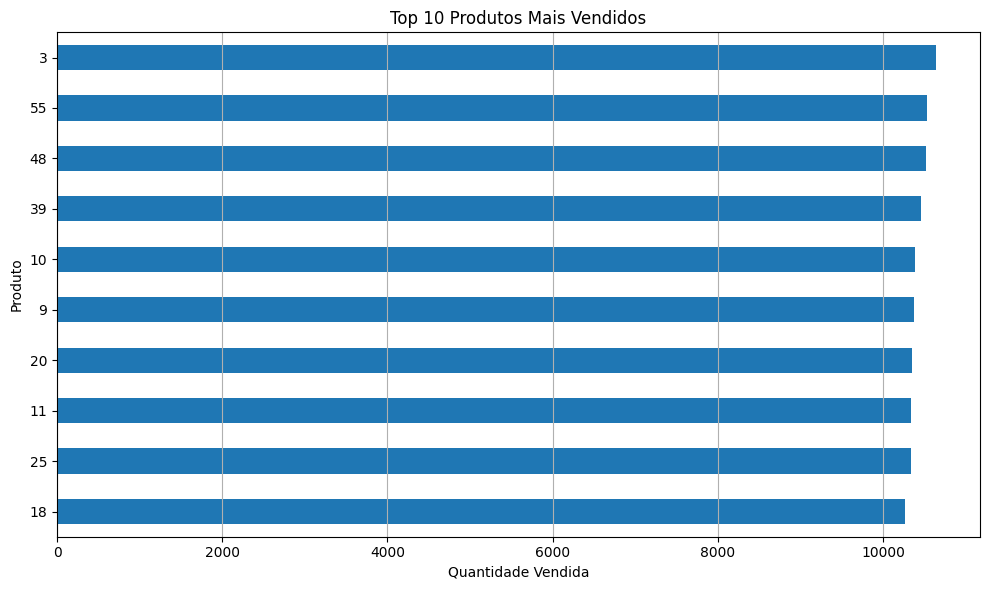

In [10]:
# 📊 Visualizar os 10 produtos mais vendidos em um gráfico de barras horizontais
df_top_products.sort_values("total_quantity", ascending=True).plot(
    kind="barh", 
    x="id_produto", 
    y="total_quantity", 
    figsize=(10, 6), 
    legend=False
)

plt.title("Top 10 Produtos Mais Vendidos")
plt.xlabel("Quantidade Vendida")
plt.ylabel("Produto")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# **3. Segmentação de Lojas com K-means Clustering**

Vamos usar o **BigQuery ML** para agrupar os pontos de venda com base em sua atividade de vendas usando o algoritmo de K-means. A segmentação considerará as seguintes métricas:

- Receita total (`SUM(total)`)
- Número de transações (`COUNT(*)`)
- Tamanho médio do ticket (`AVG(total)`)

Isso nos ajudará a segmentar as lojas de acordo com o seu desempenho.



In [11]:
# 🛠️ Criar ou substituir a tabela com features por loja e produto
query_create_store_product_features = f"""
CREATE OR REPLACE TABLE `{projeto}.{dataset}.store_product_features` AS
SELECT
  A.id_ponto_venda,
  B.id_produto,
  COUNT(*) AS num_transactions,
  SUM(B.quantidade) AS total_quantity,
  AVG(A.total) AS total_sales
FROM `{projeto}.{dataset}.vendas` AS A
LEFT JOIN `{projeto}.{dataset}.detalhes_de_venda` AS B
  ON A.id_venda = B.id_venda
GROUP BY A.id_ponto_venda, B.id_produto
"""

# 🚀 Executar a query de criação da tabela no BigQuery
bqclient.query(query_create_store_product_features).result()
print("✅ Tabela 'store_product_features' criada com sucesso no BigQuery.")

✅ Tabela 'store_product_features' criada com sucesso no BigQuery.


Agora vamos criar um modelo K-means no BigQuery ML utilizando as features das lojas. Usaremos num_clusters = 4 como exemplo.


In [12]:
# 🧠 Criar modelo K-means no BigQuery ML com 4 clusters, utilizando as features das lojas
query_create_kmeans_model = f"""
CREATE OR REPLACE MODEL `{projeto}.{dataset}.kmeans_store_segmentation`
OPTIONS (
  model_type = 'kmeans',
  num_clusters = 4,
  standardize_features = TRUE
) AS
SELECT
  num_transactions,
  total_quantity,
  total_sales
FROM `{projeto}.{dataset}.store_product_features`
"""

# 🚀 Executar a criação do modelo no BigQuery ML
bqclient.query(query_create_kmeans_model).result()
print("✅ Modelo K-means criado com sucesso no BigQuery.")

✅ Modelo K-means criado com sucesso no BigQuery.


Vamos avaliar o desempenho do agrupamento. O BigQuery ML fornece métricas como o **Índice de Davies-Bouldin** e a **soma dos quadrados intra-cluster**.


In [13]:
# 📊 Avaliar o desempenho do modelo K-means treinado com BigQuery ML
query_evaluation = f"""
SELECT *
FROM ML.EVALUATE(
  MODEL `{projeto}.{dataset}.kmeans_store_segmentation`
)
"""

# 🔄 Executar a consulta e carregar o resultado em um DataFrame
df_evaluation = read_gbq(query_evaluation, project_id=project_id)
df_evaluation.head()

Downloading: 100%|██████████|


,davies_bouldin_index,mean_squared_distance
0,1.09133,1.085809


📊 Após o treinamento de um modelo K-means no BigQuery ML, duas métricas chave são fornecidas para avaliar a qualidade do agrupamento:

### 1. `davies_bouldin_index`

- 📏 Mede o quão bem separados os clusters estão.
- ✅ **Quanto menor, melhor** — valores próximos a 0 indicam clusters compactos e bem separados.
- 👍 Um valor abaixo de **1.0** é geralmente considerado bom.

**Resultado:**
`davies_bouldin_index = 1.09133`
🎉 Este é um **bom resultado**, sugerindo que os clusters estão **bem separados**.


### 2. `mean_squared_distance`

- 📐 Distância média quadrática de cada ponto ao centroide do seu cluster.
- 🎯 Valores mais baixos indicam **clusters mais coesos e apertados**.
- ⚖️ Este valor depende da escala — use-o para comparar entre diferentes `k`.

**Resultado:**
`mean_squared_distance = 1.08509`
✅ Indica que, em média, os pontos estão **próximos de seus centroides**, o que suporta clusters compactos.

## 💡 Recomendação

Para validar o modelo ou explorar melhorias:

1. 🧪 Experimente diferentes valores de `k` (por exemplo, 3, 4, 5)
2. 📈 Acompanhe ambas as métricas para encontrar a configuração ideal:

| k (clusters) | Índice de Davies-Bouldin | Distância Média Quadrática |
|--------------|--------------------------|----------------------------|
| 3            | ?                        | ?                          |
| 4 (seu modelo) | **1.09133** | **1.08509** |
| 5            | ?                        | ?                          |

📉 Valores mais baixos são preferíveis para ambas as métricas — monitore as mudanças conforme você ajusta o modelo.

Escolha o modelo com o **menor Índice de Davies-Bouldin** e **clusters compactos** (baixa distância).


Agora usamos o modelo para atribuir cada loja a um dos clusters.

In [14]:
# 🔮 Aplicar o modelo K-means para prever o cluster de cada ponto de venda
query_predict = f"""
SELECT *
FROM ML.PREDICT(
  MODEL `{projeto}.{dataset}.kmeans_store_segmentation`,
  TABLE `{projeto}.{dataset}.store_product_features`
)
"""

# 📥 Executar a consulta e carregar os resultados como DataFrame
df_store_product_clusters = read_gbq(query_predict, project_id=project_id)
df_store_product_clusters.head()

Downloading: 100%|██████████|


,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,id_ponto_venda,id_produto,num_transactions,total_quantity,total_sales
0,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.628870024722...",6,16,99,538,531.930505
1,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.401556949379...",7,51,96,528,576.097604
2,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.890608355127...",7,6,98,490,541.048367
3,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.033662637362...",1,38,103,590,525.399029
4,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.931759635500...",13,45,98,550,547.444184


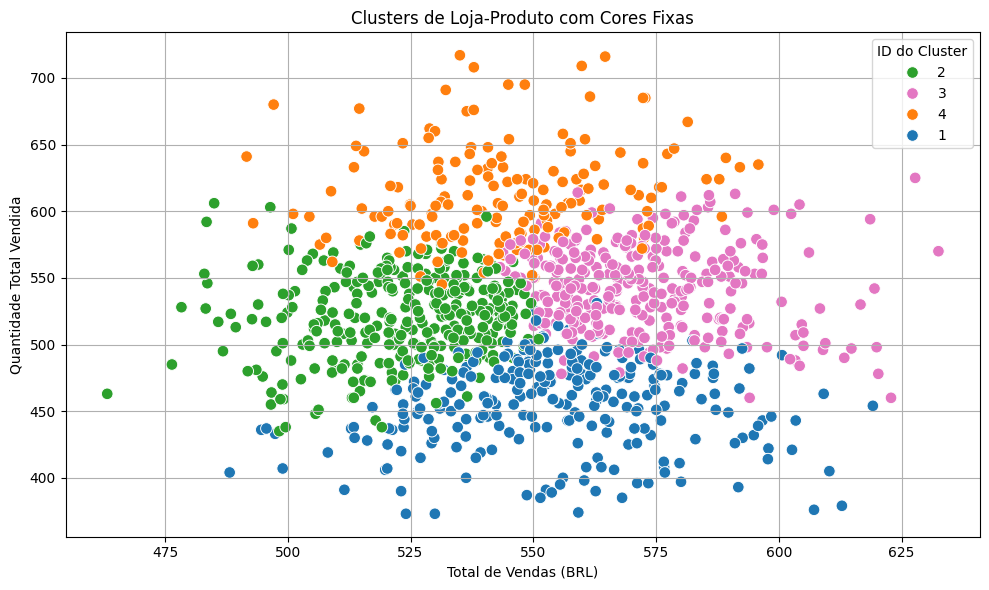

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Definir um mapeamento fixo de cores por ID de cluster
palette_custom = {
    "1": "#1f77b4",  # azul
    "2": "#2ca02c",  # verde
    "3": "#e377c2",  # rosa
    "4": "#ff7f0e",  # laranja
}

# 🔄 Garantir que o cluster esteja como string
df_store_product_clusters["CENTROID_ID"] = df_store_product_clusters["CENTROID_ID"].astype(str)

# 📈 Visualizar os clusters com cores fixas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_store_product_clusters,
    x="total_sales",
    y="total_quantity",
    hue="CENTROID_ID",
    palette=palette_custom,
    s=70
)

plt.title("Clusters de Loja-Produto com Cores Fixas")
plt.xlabel("Total de Vendas (BRL)")
plt.ylabel("Quantidade Total Vendida")
plt.grid(True)
plt.legend(title="ID do Cluster")
plt.tight_layout()
plt.show()

## **Interpretando os Clusters de Loja-Produto**

O gráfico de dispersão acima mostra os resultados de um modelo de **clusterização K-means** aplicado aos dados **loja-produto**, utilizando:

- **Eixo X**: `Total de Vendas (R$)`
- **Eixo Y**: `Quantidade Total Vendida`
- **Cores**: `ID do Cluster` atribuída pelo modelo com paleta **fixa**.

Cada ponto representa um **par loja-produto**, ou seja, o quanto uma loja vendeu de determinado produto em quantidade e valor.

---

### 🎯 **Interpretação com base na visualização atual**

| Cor do cluster | ID do cluster | Posição no gráfico (X/Y)       | Interpretação sugerida                                            |
|----------------|----------------|-------------------------------|-------------------------------------------------------------------|
| 🔵 Azul         | 1              | Baixo Y, médio-alto X         | Produtos de **médio valor**, com **baixa rotação**               |
| 🟢 Verde        | 2              | Médio Y, baixo X              | Produtos com **quantidade razoável**, mas **baixo faturamento** |
| 🌸 Rosa         | 3              | Alto Y, alto X                | **Produtos populares e de bom valor** → alto volume e valor      |
| 🟠 Laranja      | 4              | Alto Y, médio X               | **Produtos de alta quantidade**, mas com valor **intermediário** |

> 💡 A paleta foi fixada com: `azul = 1`, `verde = 2`, `rosa = 3`, `laranja = 4`  
> Isso permite uma interpretação consistente em cada execução do notebook.

---

### 📌 Perguntas para Discussão

- Qual grupo representa produtos **de giro rápido e preço acessível**?
- Qual cluster parece indicar produtos **de baixo valor ou pouco atrativos**?
- Há algum cluster que represente **produtos premium ou exclusivos**?
- Como você pode usar isso para **planejar mix de produtos ou promoções**?

---

A clusterização é uma ferramenta poderosa para segmentar vendas e apoiar decisões comerciais com base em dados reais.

# 📈 **4. Previsão de Vendas Semanais com ARIMA_PLUS**

Nesta seção, vamos prever as vendas totais utilizando o modelo de séries temporais `ARIMA_PLUS` do BigQuery ML.

Etapas que iremos seguir:

1. 🗓️ **Agrupar vendas por semana**
   Consolidaremos os dados para obter o total de vendas em cada semana.

2. 🧠 **Treinar o modelo de previsão**
   Utilizaremos `ARIMA_PLUS`, que é um modelo robusto para séries temporais com tendência, sazonalidade e componentes de erro.

3. ✅ **Avaliar a acurácia do modelo**
   Verificaremos métricas como RMSE para entender o desempenho da previsão no histórico.

4. 🔮 **Prever vendas semanais futuras**
   Geraremos previsões para as próximas semanas com base nos padrões anteriores.

5. 📊 **Visualizar a previsão com intervalos de confiança**
   Construiremos um gráfico com a série histórica, a previsão e as bandas de incerteza.

Com isso, você poderá observar tendências e preparar decisões baseadas em dados projetados no futuro.

In [16]:
# 📆 Criar a tabela de vendas semanais no BigQuery (evita semanas incompletas)
query_create_weekly_sales = f"""
CREATE OR REPLACE TABLE `{projeto}.{dataset}.weekly_sales` AS
SELECT
  DATE_TRUNC(data_venda, WEEK(MONDAY)) AS week,
  SUM(total) AS weekly_sales
FROM `{projeto}.{dataset}.vendas`
WHERE data_venda < DATE_SUB('2024-07-15', INTERVAL 7 DAY)  -- avoid incomplete weeks
GROUP BY week
ORDER BY week
"""

# 🚀 Executar a criação da tabela semanal
bqclient.query(query_create_weekly_sales).result()
print("✅ Tabela 'weekly_sales' criada com sucesso no BigQuery.")

✅ Tabela 'weekly_sales' criada com sucesso no BigQuery.


📊 Agora criaremos um modelo de série temporal com um horizonte de previsão de 12 semanas usando `ARIMA_PLUS`.

In [17]:
# 🔮 Criar modelo ARIMA_PLUS no BigQuery ML para prever 12 semanas futuras
query_create_arima_model = f"""
CREATE OR REPLACE MODEL `{projeto}.{dataset}.sales_forecast_model`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'week',
  time_series_data_col = 'weekly_sales',
  data_frequency = 'WEEKLY',
  horizon = 12,
  auto_arima = TRUE,         -- ativa a seleção automática de hiperparâmetros
  holiday_region = 'BR'      -- adiciona efeitos de feriados brasileiros
) AS
SELECT * FROM `{projeto}.{dataset}.weekly_sales`
"""

# 🚀 Executar a criação do modelo no BigQuery ML
bqclient.query(query_create_arima_model).result()
print("✅ Modelo ARIMA_PLUS criado com sucesso.")

✅ Modelo ARIMA_PLUS criado com sucesso.


📊 Vamos verificar a precisão do modelo de previsão usando métricas de avaliação.

In [18]:
# 📈 Avaliar o desempenho do modelo ARIMA_PLUS treinado
query_evaluate_forecast_model = f"""
SELECT *
FROM ML.EVALUATE(
  MODEL `{projeto}.{dataset}.sales_forecast_model`
)
"""

# 🔄 Executar a consulta e carregar os resultados como DataFrame
df_evaluation = read_gbq(query_evaluate_forecast_model, project_id=project_id)
df_evaluation

Downloading: 100%|██████████|


,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,1,0,1,False,-1024.773214,2057.546428,1.686799e+08,[NO_SEASONALITY],True,False,False
1,3,0,0,False,-1024.297192,2058.594384,1.704284e+08,[NO_SEASONALITY],True,False,False
2,0,0,0,False,-1027.389651,2058.779301,1.823571e+08,[NO_SEASONALITY],True,False,False
3,0,0,3,False,-1024.405938,2058.811877,1.708144e+08,[NO_SEASONALITY],True,False,False
4,0,0,2,False,-1025.963733,2059.927466,1.767525e+08,[NO_SEASONALITY],True,False,False
5,2,0,1,False,-1024.966424,2059.932847,1.729405e+08,[NO_SEASONALITY],True,False,False
6,1,0,2,False,-1025.103960,2060.207920,1.734553e+08,[NO_SEASONALITY],True,False,False
7,0,0,1,False,-1027.242867,2060.485734,1.817794e+08,[NO_SEASONALITY],True,False,False
8,1,0,0,False,-1027.284989,2060.569979,1.819471e+08,[NO_SEASONALITY],True,False,False
9,2,0,0,False,-1026.467753,2060.935506,1.787415e+08,[NO_SEASONALITY],True,False,False


## ⚙️ **Melhores Parâmetros do Modelo ARIMA_PLUS (Avaliado pelo BigQuery ML)**

Após o treinamento, o BigQuery ML testou diversas combinações de parâmetros ARIMA não sazonais para encontrar o modelo com melhor desempenho.

Com base no menor valor de AIC e maior log-verossimilhança, o **modelo mais eficaz** usa a seguinte configuração:

| Parâmetro              | Valor            |
|------------------------|------------------|
| `non_seasonal_p`       | 1                |
| `non_seasonal_d`       | 0                |
| `non_seasonal_q`       | 1                |
| `has_drift`            | False            |
| `seasonal_periods`     | [NO_SEASONALITY] |
| `log_likelihood`       | -1024.77         |
| `AIC`                  | 2057.54          |
| `variance`             | 1.686799e+08     |
| `has_holiday_effect`   | True             |

---

## 🔍 **Interpretação**

- **ARIMA(1,0,1)**: O modelo utiliza 1 termo autorregressivo e 1 termo de média móvel, assumindo que a série é estacionária (não necessita diferenciação).
- 🗓️ **Nenhuma sazonalidade** foi detectada — não há padrões semanais ou mensais repetitivos nos dados.
- 🎯 **Efeito de feriados**: Detectado efeito significativo dos feriados sobre as vendas (`has_holiday_effect = True`).
- 🔮 Esse modelo está pronto para gerar previsões confiáveis para as **próximas semanas**, considerando o efeito dos feriados.


In [19]:
# 🔮 Gerar previsões para as próximas 12 semanas com o modelo ARIMA_PLUS
query_forecast = f"""
SELECT *
FROM ML.FORECAST(
  MODEL `{projeto}.{dataset}.sales_forecast_model`,
  STRUCT(12 AS horizon)
)
"""

# 🔄 Executar a previsão e carregar como DataFrame
df_forecast = read_gbq(query_forecast, project_id=project_id)
df_forecast.head()

Downloading: 100%|██████████|


,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2024-07-08 00:00:00+00:00,266395.229644,13048.127659,0.95,240867.114704,291923.344585,240867.114704,291923.344585
1,2024-07-15 00:00:00+00:00,264275.019355,13160.403885,0.95,238527.240683,290022.798027,238527.240683,290022.798027
2,2024-07-22 00:00:00+00:00,264209.114213,13242.633280,0.95,238300.457178,290117.771249,238300.457178,290117.771249
3,2024-07-29 00:00:00+00:00,264152.504033,13302.977924,0.95,238125.785230,290179.222836,238125.785230,290179.222836
4,2024-08-05 00:00:00+00:00,264103.877895,13347.326509,0.95,237990.392943,290217.362847,237990.392943,290217.362847


In [20]:
# 📅 Consultar a série histórica de vendas semanais
query_weekly_sales = f"""
SELECT *
FROM `{projeto}.{dataset}.weekly_sales`
ORDER BY week
"""

# 🔄 Executar a consulta e carregar como DataFrame pandas
df_weekly_sales = read_gbq(query_weekly_sales, project_id=project_id)
df_weekly_sales = df_weekly_sales.sort_values("week")

Downloading: 100%|██████████|


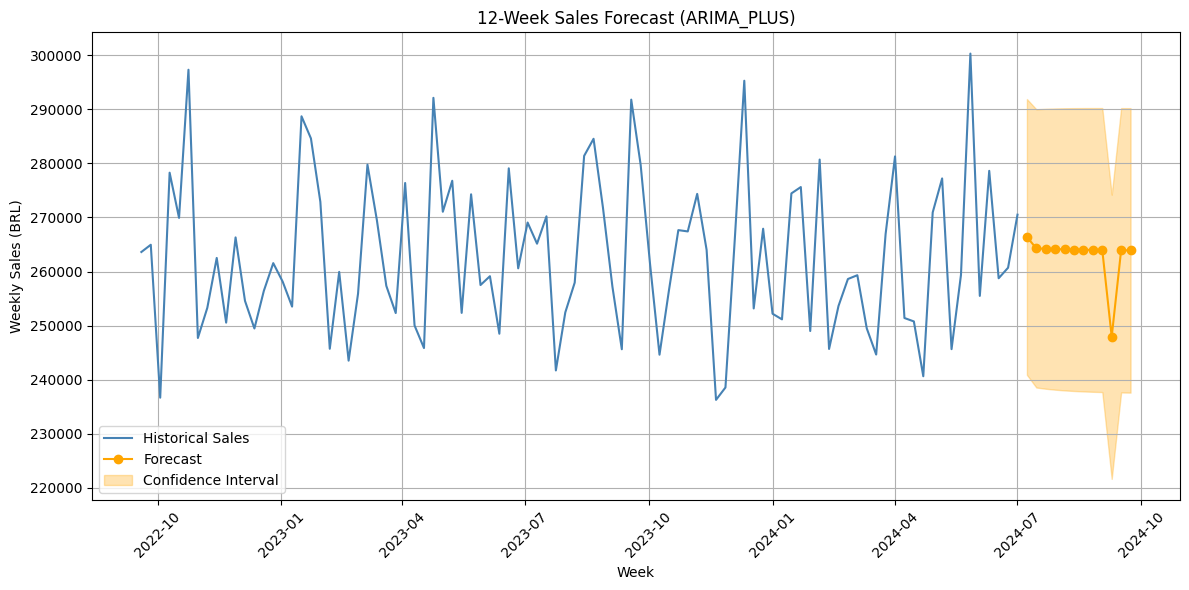

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Historical sales line
plt.plot(df_weekly_sales['week'], df_weekly_sales['weekly_sales'], label='Historical Sales', color='steelblue')

# Forecasted sales
plt.plot(df_forecast['forecast_timestamp'], df_forecast['forecast_value'], label='Forecast', color='orange', marker='o')

# Confidence interval
plt.fill_between(
    df_forecast['forecast_timestamp'],
    df_forecast['prediction_interval_lower_bound'],
    df_forecast['prediction_interval_upper_bound'],
    color='orange',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title("12-Week Sales Forecast (ARIMA_PLUS)")
plt.xlabel("Week")
plt.ylabel("Weekly Sales (BRL)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🧹 ## **Limpando Outliers em Séries Temporais de Vendas**

Ao trabalhar com dados de séries temporais, especialmente de **vendas** 🛒, é essencial **inspecionar os valores mais recentes** 👀 antes de treinar um modelo de previsão 🧠. Anomalias como **quedas ou picos abruptos** 📉📈 podem distorcer os resultados e gerar previsões imprecisas 🚫.

---

### **Causas Comuns de Outliers**

Um problema frequente é uma **queda repentina na última semana** 🗓️ dos dados históricos. Isso pode ocorrer por:

- ⏳ **Semanas incompletas** (por exemplo, quando a semana ainda não terminou)
- 🐌 **Atrasos na ingestão de dados** (transações ausentes)
- 🛑 **Interrupções nas vendas** (feriados 🏖️, problemas de estoque 📦, lojas fechadas 🚪)
- 💻 **Erros de sistema** na coleta dos dados

Esses valores geralmente **não representam a tendência real** 📊 e podem precisar ser removidos ✂️ ou ajustados 🔧.

---

### **Atividade Sugerida para Exploração**

Convide os participantes a inspecionar a série histórica de vendas 🔍 e aplicar técnicas de **detecção de outliers**, como:

- 📊 **Intervalo Interquartil (IQR)** para detectar e remover valores muito baixos.
- 🔢 **Regras estatísticas**, como pontuações Z (Z-score) ou limites com janelas móveis.
- 🖐️ **Inspeção manual** das últimas semanas (ex: `df.tail(5)` no Python).

#### 💻 Exemplo em Python:

```python
q1 = df['weekly_sales'].quantile(0.25)
q3 = df['weekly_sales'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr

df_clean = df[df['weekly_sales'] > lower_bound]
```

# **5. Previsão de Séries Temporais com Vertex AI (usando XGBoost + Custom Job)**

Além do BigQuery ML, o Google Cloud oferece o **Vertex AI Training com Custom Jobs** — uma solução flexível e altamente personalizável para **construção, treinamento e implantação de modelos de previsão em escala**.

---

## 🧠 O que é um Custom Job no Vertex AI?

Custom Jobs permitem executar qualquer código de treinamento, usando bibliotecas como:

- XGBoost  
- scikit-learn  
- LightGBM  
- TensorFlow, PyTorch ou qualquer outro pacote customizado

💡 Esses modelos são ideais para:

- 🛍️ Previsão de vendas no varejo  
- 📦 Otimização de inventário e reabastecimento  
- 📈 Modelagem de séries financeiras  
- 🔧 Análise de séries temporais industriais (IoT, sensores, etc.)

---

## ⚙️ O que vamos fazer neste notebook?

Neste exemplo **não usaremos AutoML Forecasting diretamente**, pois queremos demonstrar como:

> **Treinar e implantar um modelo de previsão com XGBoost manualmente usando Vertex AI Custom Job.**

O fluxo será:

1. 📊 Carregar e preparar a série temporal com lags e variáveis de calendário  
2. ⚙️ Treinar um modelo XGBoost manualmente via `train.py`  
3. 📦 Empacotar o código e enviá-lo para o Vertex AI (GCS + Custom Job)  
4. 🧠 Treinar o modelo em uma máquina virtual com XGBoost  
5. 💾 Salvar o modelo no GCS e registrar no **Model Registry**  
6. 🚀 Implantar o modelo como um endpoint no Vertex AI (opcional)

---

## 🛠️ Por que usar XGBoost neste caso?

- ✅ Excelente desempenho com poucos dados  
- ✅ Robusto a outliers e ruídos  
- ✅ Fácil de ajustar e interpretar a importância dos atributos  
- ✅ Permite controle total sobre a engenharia de features  
- ✅ Ótima performance para séries temporais com lags e tendências

---

## ⚖️ Vertex AI Custom Job vs. BigQuery ML

| Recurso                                | BigQuery ML (ARIMA_PLUS)     | Vertex AI (XGBoost + Custom Job)     |
|----------------------------------------|-------------------------------|--------------------------------------|
| Tipo de modelo                         | ARIMA                         | Regressão com lags (XGBoost)         |
| Suporte a múltiplas séries             | Parcial                       | ✅ Com manipulação em Python         |
| Feature engineering                    | Mínimo                        | ✅ Totalmente personalizável          |
| Controle do treinamento                | Limitado                      | ✅ Código 100% customizado            |
| Escalabilidade                         | SQL                           | ✅ VMs dedicadas e distribuídas       |
| Implantação com API                    | Parcial                       | ✅ Pronta para produção               |

---

## 📚 Recursos Recomendados

- [Documentação do Vertex AI Custom Job](https://cloud.google.com/vertex-ai/docs/training/create-custom-job)  
- [Exemplo oficial com XGBoost](https://cloud.google.com/vertex-ai/docs/training/custom-training)

---

🧪 Agora vamos construir nosso **modelo XGBoost manualmente**, empacotar e treiná-lo com **Vertex AI Custom Job**, e ao final, registrar no **Model Registry do Vertex AI**!


# **Guia Passo a Passo: Previsão de Séries Temporais com Vertex AI (usando XGBoost + Custom Job)**

Neste guia, vamos mostrar como realizar **uma previsão de séries temporais com XGBoost**, utilizando dados semanais armazenados no **BigQuery**, e executando todas as etapas dentro do ambiente **Vertex AI Workbench** com um **Custom Job**.

> ⚠️ Não utilizaremos AutoML Forecasting neste fluxo — a ideia aqui é montar um pipeline manual:  
> **extração de dados → engenharia de features → treino com XGBoost → registro no Vertex AI (Model Registry)**.

---

## ✅ **Pré-requisitos**

Antes de começar, verifique se você possui:

### 📊 **Uma tabela no BigQuery com seus dados históricos agregados por semana**

A tabela deve conter pelo menos as seguintes colunas:

| Nome da Coluna   | Descrição                                             |
|------------------|-------------------------------------------------------|
| `week`           | Data de referência semanal (`DATE_TRUNC(data, WEEK)`)|
| `weekly_sales`   | Valor agregado da variável resposta (ex: vendas)      |

> 💡 No pré-processamento, vamos criar **lags**, **variáveis de tempo** e preparar a matriz de entrada para o XGBoost.

---

## 🧪 **Criar a Tabela no BigQuery (caso ainda não tenha feito)**

Se você ainda não tiver criado a tabela de vendas semanais, execute a seguinte consulta SQL no editor do BigQuery:


In [22]:
from pandas_gbq import read_gbq
import pandas as pd

# 🔎 Consulta SQL para selecionar os dados da tabela já existente no BigQuery
query = f"""
SELECT
  week,                -- Coluna com a data da semana (já agregada anteriormente)
  weekly_sales         -- Total de vendas por semana
FROM `{projeto}.{dataset}.weekly_sales`
ORDER BY week          -- Ordena os registros por ordem cronológica
"""

# 🔄 Executa a consulta no BigQuery e carrega os dados em um DataFrame
df_weekly_sales = read_gbq(query, project_id=project_id)

# 🧹 Ordena as semanas em ordem crescente para garantir consistência temporal
df_weekly_sales = df_weekly_sales.sort_values("week")

# 💾 Salva os dados como um arquivo CSV localmente (útil para upload posterior ao GCS)
df_weekly_sales.to_csv("weekly_sales.csv", index=False)

# 👀 Exibe as primeiras linhas do DataFrame para inspeção
df_weekly_sales.head()

Downloading: 100%|██████████|


,week,weekly_sales
0,2022-09-19,263613.03
1,2022-09-26,264951.95
2,2022-10-03,236646.96
3,2022-10-10,278292.92
4,2022-10-17,269928.74


In [23]:
# 🔍 Consultar a quantidade de registros na tabela 'vertex_daily_sales'
query_count_rows = f"""
SELECT COUNT(*) AS total_linhas
FROM `{projeto}.{dataset}.vertex_daily_sales`
"""

df_prueba = read_gbq(query_count_rows, project_id=project_id)
df_prueba

Downloading: 100%|██████████|


,total_linhas
0,731


## 📤 Etapa: Enviar dados para o Google Cloud Storage

Depois de gerar o arquivo CSV com os dados semanais de vendas, precisamos enviá-lo para um **bucket no GCS (Google Cloud Storage)**. Esse arquivo será utilizado mais adiante pelo job de treinamento no **Vertex AI**.

> ⚠️ **Certifique-se de que o bucket já exista e que você tenha permissões de escrita.**

In [31]:
# 📦 Importa a biblioteca do cliente do Google Cloud Storage
from google.cloud import storage

# 🪣 Define o nome do bucket do GCS e os caminhos do arquivo
bucket_name = "bootcamp-brasil-central1-v1"       # Nome do bucket onde o arquivo será salvo
destination_blob = "data/weekly_sales.csv"     # Caminho dentro do bucket (como se fosse uma pasta/arquivo)
source_file = "weekly_sales.csv"               # Caminho local do arquivo CSV que será enviado

# 🚀 Inicializa o cliente do GCS com o projeto associado
client = storage.Client(project=project_id)

# 📂 Recupera o bucket e cria o blob (representação do arquivo no GCS)
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob)

# ⬆️ Realiza o upload do arquivo CSV do disco local para o GCS
blob.upload_from_filename(source_file)

# ✅ Confirma que o arquivo foi enviado com sucesso
print(f"✅ Archivo subido a gs://{bucket_name}/{destination_blob}")


✅ Archivo subido a gs://bootcamp-brasil-central1-v1/data/weekly_sales.csv


## 🧠 Script de Treinamento: `train.py`

Este script define um pipeline completo para **treinar um modelo de previsão com XGBoost** usando dados semanais de vendas armazenados no **Google Cloud Storage (GCS)** e exportar o modelo treinado para o bucket.

---


In [32]:
%%writefile train.py
import pandas as pd
import xgboost as xgb
import joblib
import os
from google.cloud import storage

# 🔽 Função para baixar o CSV do GCS para o disco local (/tmp)
def download_csv_from_gcs(bucket_name, source_blob, dest_file):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob)
    blob.download_to_filename(dest_file)

# 🛠️ Função de engenharia de atributos
def create_features(df):
    df["week"] = pd.to_datetime(df["week"])
    df = df.sort_values("week")
    df["week_number"] = (df["week"] - df["week"].min()).dt.days
    df["week_of_year"] = df["week"].dt.week  # compatível com Python 3.7
    df["lag_1"] = df["weekly_sales"].shift(1)
    df["lag_2"] = df["weekly_sales"].shift(2)
    df["lag_3"] = df["weekly_sales"].shift(3)
    df = df.dropna().reset_index(drop=True)
    return df

# 🚀 Função principal
def main():
    bucket_name = "bootcamp-brasil-central1-v1"
    blob_path = "data/weekly_sales.csv"
    local_path = "/tmp/weekly_sales.csv"

    download_csv_from_gcs(bucket_name, blob_path, local_path)
    df = pd.read_csv(local_path)
    df = create_features(df)

    X = df[["lag_1", "lag_2", "lag_3", "week_of_year"]]
    y = df["weekly_sales"]

    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    local_model_path = "/tmp/model.bst"
    joblib.dump(model, local_model_path)

    output_dir = os.environ["AIP_MODEL_DIR"].rstrip("/")
    model_filename = "model.bst"

    # Subir archivo local al bucket de GCS
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(f"{output_dir.split('gs://'+bucket_name+'/')[1]}/{model_filename}")
    blob.upload_from_filename(local_model_path)

    print(f"✅ Modelo exportado en GCS: {output_dir}/{model_filename}")


# 🔁 Executa se for o script principal
if __name__ == "__main__":
    main()

Writing train.py


## ⚙️ Arquivo `setup.py`: Empacotando o Script de Treinamento

Este arquivo define as **configurações do pacote Python personalizado** que será executado como **Custom Job no Vertex AI**. Ele segue a estrutura padrão da ferramenta `setuptools`.

---

### 📌 Objetivo

- Empacotar os arquivos do diretório `trainer/` (onde está o `train.py`) como um **módulo Python instalável**.
- Declarar **dependências** que precisam ser instaladas no ambiente do contêiner.
- Definir um **ponto de entrada** para que o Vertex AI saiba **qual função executar** durante o job.


In [33]:
%%writefile setup.py
from setuptools import setup  # 📦 Utilitário para empacotar e instalar o módulo como pacote Python

# 📌 Definição do pacote "trainer"

setup(
    name="trainer",           # Nome do pacote
    version="0.1",            # Versão do pacote
    packages=["trainer"],     # Pasta que contém o código-fonte (trainer/train.py)

    # 📦 Dependências necessárias para rodar o script
    install_requires=[
        "pandas",               # Manipulação de dados
        "xgboost",              # Algoritmo de regressão
        "joblib",               # Para salvar e carregar modelos
        "google-cloud-storage"  # Para baixar arquivos do GCS
    ],

    # 🚀 Ponto de entrada para execução no Vertex AI
    entry_points={
        "console_scripts": ["train=trainer.train:main"],  # Executa trainer/train.py:main como script
    },
)

Writing setup.py


## 🏗️ Preparando a Estrutura do Pacote para Treinamento no Vertex AI

Para executar um **Custom Job** no Vertex AI usando um script Python personalizado, precisamos **empacotar nosso código** como um módulo Python válido. Esta etapa garante que o Vertex consiga localizar e executar corretamente a função principal (`main`) do nosso modelo.

---

### 📁 Estrutura Esperada pelo Vertex AI

O Vertex AI espera que o seu módulo esteja em um **pacote Python bem definido** com esta estrutura:



In [34]:
# 📁 Cria a estrutura de diretórios esperada por Python para pacotes
# Isso garante que exista uma pasta "trainer/trainer/"
!mkdir -p trainer/trainer

# 🚚 Move o script de treino para dentro da subpasta "trainer/"
# Assim, o Python reconhece a estrutura como um pacote
!mv train.py trainer/trainer/

# 📦 Move o setup.py para a raiz da pasta "trainer"
!mv setup.py trainer/

# 🧩 Cria o arquivo __init__.py vazio para tornar o diretório um pacote Python válido
!touch trainer/trainer/__init__.py

# 📦 Empacota o módulo com setuptools no formato tar.gz
!cd trainer && python3 setup.py sdist --formats=gztar

# ☁️ Envia o pacote gerado para o bucket do Google Cloud Storage
!gsutil cp trainer/dist/trainer-0.1.tar.gz gs://bootcamp-brasil-central1-v1/packages/


running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing entry points to trainer.egg-info/entry_points.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check
creating trainer-0.1
creating trainer-0.1/trainer
creating trainer-0.1/trainer.egg-info
copying files to trainer-0.1...
copying setup.py -> trainer-0.1
copying trainer/__init__.py -> trainer-0.1/trainer
copying trainer/train.py -> trainer-0.1/trainer
copying trainer.egg-info/PKG-INFO -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/entry_points.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/requires.txt ->

## 🚀 Etapa: Criando um Custom Job com Vertex AI (XGBoost)

Nesta etapa, vamos configurar e registrar um **job de treinamento personalizado** no Vertex AI utilizando:

- 📦 Um pacote Python (.tar.gz) previamente empacotado
- 🐍 Um script de treinamento que está dentro de um módulo (`trainer/train.py`)
- 🧠 Um modelo baseado em **XGBoost**
- 🔧 Uma imagem de container oficial para treinamento e outra para servir o modelo

In [35]:
from google.cloud import aiplatform

# 🔧 Inicializa Vertex AI com projeto, localização e bucket para staging
aiplatform.init(
    project="bc-gcp-servibrasil-25-servi",
    location="us-central1",
    staging_bucket="gs://bootcamp-brasil-central1-v1"
)

# 🚀 Cria um job de treinamento com pacote Python personalizado (Custom Job)
job = aiplatform.CustomPythonPackageTrainingJob(
    display_name="xgb-weekly-forecast",  # Nome visível do job
    python_package_gcs_uri="gs://bootcamp-brasil-central1-v1/packages/trainer-0.1.tar.gz",  # URI correta!
    python_module_name="trainer.train",  # Caminho do módulo principal no pacote
    container_uri="us-docker.pkg.dev/vertex-ai/training/scikit-learn-cpu.0-23:latest",  # Container base para treino
    model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-1:latest"  # Container para servir o modelo
)

## ▶️ Etapa: Executar o Treinamento no Vertex AI

Agora que o `CustomPythonPackageTrainingJob` foi configurado, podemos **executar o job de treinamento** chamando o método `.run()`.

### 📌 Explicação dos Parâmetros do `job.run()`

| Parâmetro               | Tipo           | Descrição                                                                 |
|------------------------|----------------|---------------------------------------------------------------------------|
| `replica_count`        | `int`          | Número de réplicas (máquinas virtuais) utilizadas no treinamento. Normalmente 1 é suficiente para jobs simples. |
| `machine_type`         | `str`          | Especifica o tipo de máquina a ser usada (ex: `n1-standard-4`, `n1-standard-8`). Máquinas com mais CPUs e RAM treinam mais rápido. |
| `base_output_dir`      | `str` (GCS URI)| Caminho no Google Cloud Storage onde os arquivos gerados pelo treinamento (como o modelo) serão salvos. Deve começar com `gs://`. |
| `model_display_name`   | `str`          | Nome legível que será usado para registrar o modelo treinado no Vertex AI Model Registry. Serve para identificar e versionar modelos. |

---

> ℹ️ Esses parâmetros permitem **personalizar os recursos de computação**, o local de salvamento no GCS e o **registro automático do modelo** no Vertex AI.

---

### 🧠 Comando para Iniciar o Treinamento

In [36]:
# ▶️ Executa o treinamento
job.run(
    replica_count=1,  # Número de réplicas (nós)
    machine_type="n1-standard-8",  # Tipo de máquina para treinamento
    base_output_dir="gs://bootcamp-brasil-central1-v1/models/xgb_weekly",  # Caminho onde o modelo será salvo
    model_display_name="xgb-weekly-sales-model"  # Nome do modelo salvo no Vertex AI
)

Training Output directory:
gs://bootcamp-brasil-central1-v1/models/xgb_weekly 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/944764316878372864?project=781316924426
CustomPythonPackageTrainingJob projects/781316924426/locations/us-central1/trainingPipelines/944764316878372864 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5546484361911599104?project=781316924426
CustomPythonPackageTrainingJob projects/781316924426/locations/us-central1/trainingPipelines/944764316878372864 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomPythonPackageTrainingJob projects/781316924426/locations/us-central1/trainingPipelines/944764316878372864 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomPythonPackageTrainingJob projects/781316924426/locations/us-central1/trainingPipelines/944764316878372864 current state:
PipelineState.PIPELINE_STATE_

resource name: projects/781316924426/locations/us-central1/models/8709043587125346304

## 🧠 Registro do Modelo XGBoost no Model Registry do Vertex AI

Após o treinamento com um Custom Job, o modelo gerado foi salvo em um bucket no Google Cloud Storage (GCS). Agora, vamos registrá-lo no **Model Registry do Vertex AI**, o que permite:

- Armazenar versões do modelo de forma organizada
- Fazer deploy em endpoints gerenciados
- Acompanhar previsões, métricas e auditorias de forma centralizada

### ✅ Pré-requisitos
- O modelo deve estar salvo em um diretório no GCS (por exemplo: `gs://bootcamp-brasil-central1-v1/models/xgb_weekly`)
- O container de previsão deve ser compatível com o tipo de modelo (neste caso, `xgboost-cpu.1-1`)

---

In [37]:
from google.cloud import aiplatform  # 📦 Importa a biblioteca Vertex AI SDK

# 🚀 Inicializa o cliente Vertex AI com o projeto e localização padrão
aiplatform.init(
    project="bc-gcp-servibrasil-25-servi",      # 🔧 ID do seu projeto GCP
    location="us-central1"               # 🌎 Região onde o serviço será executado
)

# 📤 Registra o modelo no Vertex AI Model Registry
model = aiplatform.Model.upload(
    display_name="xgb-weekly-sales-model",  # 🏷️ Nome amigável do modelo no Vertex AI
    artifact_uri="gs://bootcamp-brasil-central1-v1/models/xgb_weekly/model",  
    # 📁 Caminho para o diretório onde está o arquivo model.bst (deve conter somente esse arquivo)

    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-1:latest"
    # 📦 Container que será usado para servir o modelo (compatível com XGBoost)
)

# ⏳ Aguarda o término do processo de upload
model.wait()

Creating Model
Create Model backing LRO: projects/781316924426/locations/us-central1/models/1557327378860998656/operations/4677439665626677248
Model created. Resource name: projects/781316924426/locations/us-central1/models/1557327378860998656@1
To use this Model in another session:
model = aiplatform.Model('projects/781316924426/locations/us-central1/models/1557327378860998656@1')


# 🚀 Implantação (Deploy) do Modelo Registrado no Vertex AI (não feito aqui, apenas para referência)

Depois de registrar o modelo XGBoost no **Model Registry do Vertex AI**, o próximo passo em ambientes de produção seria **implantá-lo (deploy)** para disponibilizá-lo via **endpoint gerenciado**, permitindo requisições de **inferência online**.

---

## ⚙️ Vertex AI para Ambientes de Produção

Em ambientes reais, o fluxo ideal seria:

1. 🔧 **Registrar o modelo** no Model Registry do Vertex AI.  
2. 🌐 **Implantar o modelo** em um endpoint escalável via `model.deploy()`.  
3. 📡 **Chamar o endpoint via REST API** para obter previsões em tempo real com dados novos.

Exemplo de código para implantar o modelo:

```python
from google.cloud import aiplatform

# Inicializa Vertex AI
aiplatform.init(project="SEU_PROJETO", location="us-central1")

# Busca o modelo pelo nome
modelo = aiplatform.Model.list(filter="display_name='xgb-weekly-sales-model'")[0]

# Faz o deploy para um endpoint
endpoint = modelo.deploy(
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1
)
```

Para mais detalhes, consulte a [documentação oficial sobre implantação (deployment) no Vertex AI](https://cloud.google.com/vertex-ai/docs/general/deployment?hl=pt-br).




# 🧪 Teste do Modelo Diretamente no Notebook

Embora seja possível implantar o modelo no Vertex AI e utilizá-lo via endpoint REST, neste notebook vamos realizar a **inferência diretamente** para fins de demonstração.

---

## ✅ Etapas

1. 📦 Baixar o modelo salvo no GCS
2. 🧠 Carregar o modelo com `joblib`
3. 🔮 Fazer uma previsão com novas entradas

In [38]:
from google.cloud import storage

# 📁 Parámetros
bucket_name = "bootcamp-brasil-central1-v1"
gcs_path = "models/xgb_weekly/model/model.bst"
local_path = "/tmp/model.bst"

# 🔽 Descargar desde GCS
storage.Client().bucket(bucket_name).blob(gcs_path).download_to_filename(local_path)
print("✅ Modelo descargado localmente:", local_path)


✅ Modelo descargado localmente: /tmp/model.bst


In [39]:
!pip install xgboost

In [40]:
import joblib
import xgboost as xgb
import pandas as pd

# 📂 Carrega o modelo local exportado anteriormente
modelo = joblib.load(local_path)

# 🧪 Cria um exemplo de entrada (com os mesmos atributos usados no treinamento)
X_novo = pd.DataFrame({
    "lag_1": [12345],
    "lag_2": [11700],
    "lag_3": [11900],
    "week_of_year": [16]  # Exemplo: semana do mês de abril
})

# 🔮 Faz a previsão com o modelo carregado
y_pred = modelo.predict(X_novo)
print("🔮 Previsão:", y_pred[0])


🔮 Previsão: 277976.53
